# Emails dataset
https://snap.stanford.edu/data/email-Eu-core.html


## 1. Load of data

In [1]:


import pandas as pd 
import os
import sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import gensim
import math

In [2]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import nltk
import pprint

from sklearn import cluster
from sklearn import metrics
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

from nltk.cluster import KMeansClusterer
import nltk
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import f1_score

from mpl_toolkits.mplot3d import Axes3D


In [3]:
edges = pd.read_csv('data/email-Eu-core.txt', sep=' ')
edges.columns=['from', 'to']
edges.head()


from  to
0     2   3
1     2   4
2     5   6
3     5   7
4     8   9

In [4]:
departments = pd.read_csv('data/email-Eu-core-department-labels.txt', sep=' ', header=None)
departments.columns=['node', 'department']
departments = departments.sort_index()


departments.head()


node  department
0     0           1
1     1           1
2     2          21
3     3          21
4     4          21

In [5]:
len(pd.unique(pd.concat([edges['from'], edges['to']], sort=False)))

1005

In [6]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 2 columns):
node          1005 non-null int64
department    1005 non-null int64
dtypes: int64(2)
memory usage: 15.8 KB


In [7]:
departments_array = []
for x, row in departments.iterrows(): 
    departments_array.append(row['department'])
    
departments_array.sort()
len(departments_array)

1005

In [8]:
#departments dictionary: node_number -> department number
departm_dic = {}
for x, row in departments.iterrows():
    departm_dic[row[0]] = row[1]
# print(departm_dic)

In [9]:
len(departm_dic)

1005

In [10]:
dep_nunique = departments.groupby('department')['node'].nunique().sort_values(ascending=False)
ten_deps = dep_nunique.head(10)

print (ten_deps)

department
4     109
14     92
1      65
21     61
15     55
7      51
0      49
10     39
17     35
9      32
Name: node, dtype: int64


In [11]:
# pick up of the ten biggest departments memebers
nodes = []
deps = []
nodes_dict = {}

for index, row in departments.iterrows():
    if (row['department'] in ten_deps):
        nodes.append(row['node'])
        deps.append(row['department'])
        nodes_dict[row['node']] = row['department']

ten_departments = pd.DataFrame(list(zip(nodes, deps)), 
               columns =['node', 'department']) 

# ten_departments.groupby('department')['node'].nunique().sort_values(ascending=False)
ten_departments.head(6)

node  department
0     0           1
1     1           1
2     2          21
3     3          21
4     4          21
5     7          14

In [12]:
len(ten_departments) #memebres of the 10 diggest depratment 

588

In [13]:
print(nodes_dict.get(2))
print(2 in nodes_dict)
print(6 in nodes_dict)

21
True
False


In [14]:
# edges for ten departments
toes = []
froms = []

for index, row in edges.iterrows():
    if (row['from'] in nodes_dict and row['to'] in nodes_dict):
        toes.append(row['to'])
        froms.append(row['from'])
 
ten_edges = pd.DataFrame(list(zip(froms, toes)), 
               columns =['from', 'to']) 

In [15]:
unique_edges = pd.unique(pd.concat([ten_edges['from'], ten_edges['to']], sort=False))
unique_edges.sort()
len(unique_edges)

568

In [16]:
#deletion nodes w/o edges from nodes_dict and ten_departments
ten_departments2 = ten_departments.set_index("node", drop = False)

for index, row in ten_departments2.iterrows():
    if (row['node'] not in unique_edges):
        ten_departments2 = ten_departments2.drop(row['node'])

len(ten_departments2)

568

In [17]:
# comparision of the nodes conected with edges and nodes in departments 
len(ten_departments2) == len(pd.unique(pd.concat([ten_edges['from'], ten_edges['to']], sort=False)))

True

## 2. Graphs construction

In [18]:
# ten biggest departments graph construction 
G = nx.Graph()
G.add_nodes_from(ten_edges['from'])
G.add_nodes_from(ten_edges['to'])

for index, row in ten_edges.iterrows():
    G.add_edge(row["from"], row["to"], weight = 1)

In [19]:
# all departments graph construction 
G_full = nx.Graph()
G_full.add_nodes_from(edges['from'])
G_full.add_nodes_from(edges['to'])

for index, row in edges.iterrows():
    G_full.add_edge(row["from"], row["to"], weight = 1)

In [20]:
print(len(G), len(G_full))

568 1005


In [21]:
dep_freq = departments['department'].value_counts()
ten_dep_freq = ten_departments['department'].value_counts()


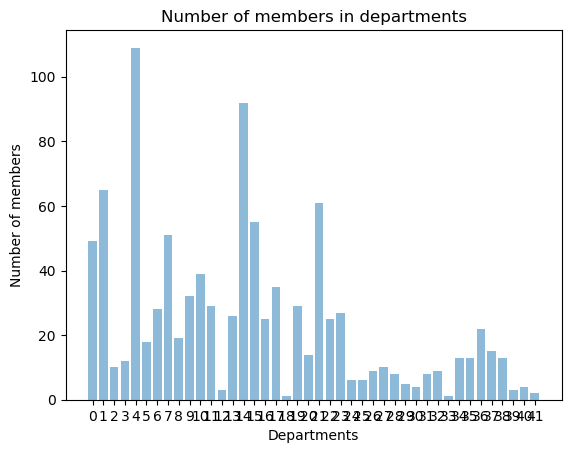

In [22]:
# all departments' members distribution
performance = []
objects = range(42)
for i in objects:
    performance.append(dep_freq[i])
y_pos = np.arange(len(objects))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of members')
plt.xlabel('Departments')
plt.title('Number of members in departments')

plt.show()

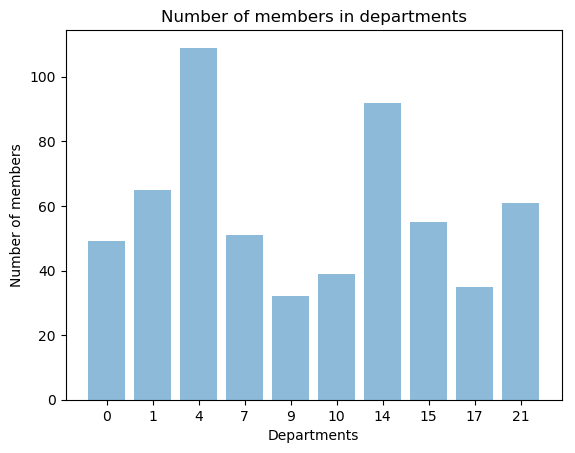

In [23]:
# ten departments' member distribution
ten_performance = []
ten_objects = ten_dep_freq.index
ten_objects = ten_objects.sort_values()
ten_objects.sort

for i in ten_objects:
    ten_performance.append(ten_dep_freq[i])

ten_y_pos = np.arange(len(ten_objects))

plt.bar(ten_y_pos, ten_performance, align='center', alpha=0.5)
plt.xticks(ten_y_pos, ten_objects)
plt.ylabel('Number of members')
plt.xlabel('Departments')
plt.title('Number of members in departments')

plt.show()

## 3. Input of the original graph for Gephi 

In [24]:
#input for Gephi - graph representation of ten biggest departments
with open('ten_data.gdf', 'w') as f:
    f.write('nodedef>name VARCHAR,department VARCHAR,label VARCHAR\n')
    for index, row in ten_departments.iterrows():
        f.write('{},{}\n'.format(row['node'], row['department']))
    f.write('edgedef>source VARCHAR,target VARCHAR, weight DOUBLE\n')
    for index, row in ten_edges.iterrows(): 
        f.write('{},{}\n'.format(row['from'], row['to'], 1))

In [25]:
#input for Gephi - graph representation of all departments
with open('data.gdf', 'w') as f:
    f.write('nodedef>name VARCHAR,department VARCHAR,label VARCHAR\n')
    for index, row in departments.iterrows():
        f.write('{},{}\n'.format(row['node'], row['department']))
    f.write('edgedef>source VARCHAR,target VARCHAR, weight DOUBLE\n')
    for index, row in edges.iterrows(): 
        f.write('{},{}\n'.format(row['from'], row['to'], 1))

## 4. Node2Vec

### Table: properties vs. adjusted_rand_score

In [26]:
# function to calculate the scores

def calc_scores (G, lables_dic, num_clusters, walk_length=80, num_walks=10, p=1, q=1):
    print ('walk_length:', walk_length, ', num_walks:', num_walks, ', p:', p, ', q:', q)
    
    #node2vec
    node2vec = Node2Vec(G, dimensions=10, walk_length = walk_length, num_walks=num_walks, p=p, q=q)
    model = node2vec.fit(window=10, min_count=1)
    
    #clustering
    print('clustering started')
    X = model[model.wv.vocab]    
    kmeans = cluster.KMeans(n_clusters=num_clusters, random_state=25)
    kmeans.fit(X)
    assigned_clusters = kmeans.labels_
    
    #labels sorting: so assigned_clusters and sorted_lables are in the same order of nodes 
    sorted_lables = []
    nodes_order = []
    nodes = list(model.wv.vocab)
    for i, node in enumerate(nodes):
        nodes_order.append(int(node))
        sorted_lables.append(lables_dic[int(node)])

    #scores
    adj_rand_score = adjusted_rand_score(assigned_clusters, sorted_lables)
#     f1_macro = f1_score(np.unique(sorted_lables), np.unique(assigned_clusters), 
#                         average='macro', labels=np.unique(assigned_clusters))  
    f1_macro = f1_score(sorted_lables, assigned_clusters, average='macro')  
    
    return adj_rand_score, f1_macro

## 4. Tables: parametres sensitivity

__Walks number sensitivity check__
* works with micro f1 score till 14 only
* bigger "window" reveals unexpected values

In [35]:
# Walks number sensitivity check 
walk_lengths_arr = []
num_walks_arr = []
adj_scores = []
f1_scores = []
clusters_10 = 10

for i in range(80, 90, 10): #walk_length = 80
    for j in range(6, 40, 1): # num_walks = 10
        adj_score, f1_macro = calc_scores(G, departm_dic, clusters_10, i, j)
        adj_scores.append(adj_score)
        f1_scores.append(f1_macro)
        walk_lengths_arr.append(i)
        num_walks_arr.append(j)

walks_test = pd.DataFrame(list(zip(walk_lengths_arr, num_walks_arr, adj_scores, f1_scores)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

walk_length: 80 , num_walks: 6 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.76s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 7 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.93s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 8 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.95s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 9 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|████████████████████████████████████████████████| 9/9 [00:24<00:00,  2.99s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:28<00:00,  3.05s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 11 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 11/11 [00:30<00:00,  3.02s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 12 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 12/12 [00:34<00:00,  3.09s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 13 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 13/13 [00:41<00:00,  3.85s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 14 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 14/14 [00:49<00:00,  3.29s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 15 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 15/15 [00:44<00:00,  3.29s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 16 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 16/16 [00:47<00:00,  3.10s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 17 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 17/17 [01:00<00:00,  3.12s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 18 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 18/18 [01:03<00:00,  4.07s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 19 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 19/19 [00:57<00:00,  3.07s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 20 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 20/20 [01:06<00:00,  4.04s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 21 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 21/21 [01:07<00:00,  3.11s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 22 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 22/22 [01:22<00:00,  3.11s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 23 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 23/23 [01:18<00:00,  4.15s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 24 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 24/24 [01:14<00:00,  3.17s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 25 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 25/25 [01:38<00:00,  3.84s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 26 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 26/26 [01:24<00:00,  3.25s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 27 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 27/27 [01:49<00:00,  3.18s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 28 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 28/28 [01:52<00:00,  4.43s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 29 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 29/29 [01:41<00:00,  5.05s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 30 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 30/30 [01:37<00:00,  3.12s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 31 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 31/31 [01:54<00:00,  4.89s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 32 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 32/32 [01:54<00:00,  3.12s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 33 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 33/33 [02:02<00:00,  3.23s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 34 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 34/34 [02:10<00:00,  5.21s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 35 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 35/35 [02:08<00:00,  5.24s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 36 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 36/36 [01:59<00:00,  3.07s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 37 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 37/37 [02:14<00:00,  3.12s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 38 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 38/38 [02:27<00:00,  3.67s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 39 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 39/39 [02:09<00:00,  3.09s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


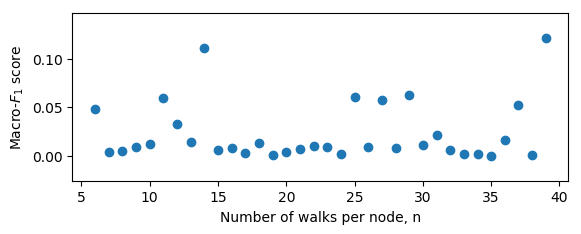

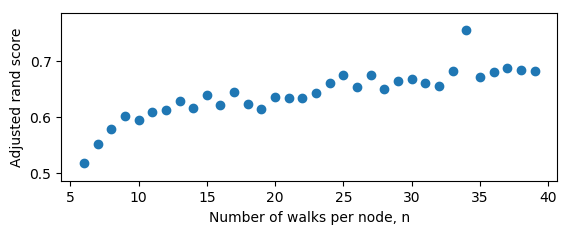

In [41]:
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(walks_test['num_walks'], walks_test['f1_score'])
plt.xlabel('Number of walks per node, n')
plt.ylabel('Macro-$F_1$ score')
plt.show()

fig = plt.figure()
fig.add_subplot(212)
plt.scatter(walks_test['num_walks'], walks_test['adj_score'])
plt.xlabel('Number of walks per node, n')
plt.ylabel('Adjusted rand score')
plt.show()

In [50]:
# the best scores
print('max f1_score:\n',walks_test.loc[walks_test['f1_score'].idxmax()], '\n')
print('max adj_score:\n',walks_test.loc[walks_test['adj_score'].idxmax()])

max f1_score:
 walk_length    80.000000
num_walks      39.000000
adj_score       0.682799
f1_score        0.121518
Name: 33, dtype: float64 

max adj_score:
 walk_length    80.000000
num_walks      34.000000
adj_score       0.754860
f1_score        0.001307
Name: 28, dtype: float64


__Walk length sensitivity check__
* random values

In [39]:
# Walk length sensitivity check 
walk_lengths_arr2 = []
num_walks_arr2 = []
adj_scores2 = []
f1_scores2 = []

for i in range(30, 200, 10): #walk_length = 80
    for j in range(10, 11, 1): # num_walks = 10
        adj_score2, f1_macro2 = calc_scores(G, departm_dic, clusters_10, i, j)
        adj_scores2.append(adj_score2)
        f1_scores2.append(f1_macro2)
        walk_lengths_arr2.append(i)
        num_walks_arr2.append(j)

length_test = pd.DataFrame(list(zip(walk_lengths_arr2, num_walks_arr2, adj_scores2, f1_scores2)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

walk_length: 30 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:10<00:00,  1.12s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 40 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:13<00:00,  1.48s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 50 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:17<00:00,  1.87s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 60 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:21<00:00,  2.37s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 70 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:25<00:00,  2.69s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:28<00:00,  3.06s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 90 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:31<00:00,  3.43s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 100 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:35<00:00,  3.80s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 110 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:45<00:00,  4.41s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 120 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:47<00:00,  4.70s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 130 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:54<00:00,  5.18s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 140 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:54<00:00,  5.50s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 150 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [01:04<00:00,  6.04s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 160 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [01:11<00:00,  8.46s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 170 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [01:12<00:00,  7.85s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 180 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [01:06<00:00,  6.98s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 190 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [01:19<00:00,  7.64s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


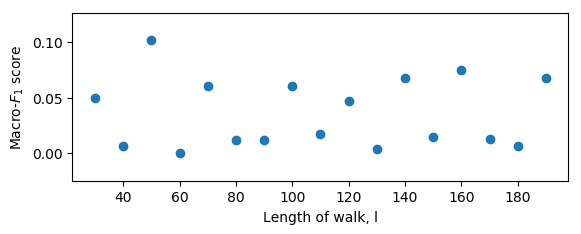

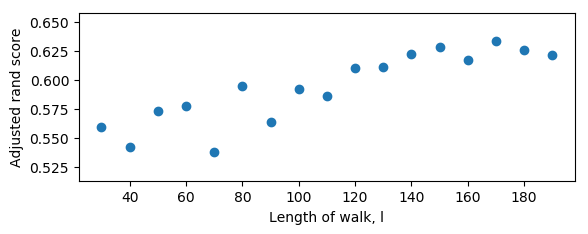

In [47]:
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(length_test['walk_length'], length_test['f1_score'])
plt.xlabel('Length of walk, l')
plt.ylabel('Macro-$F_1$ score')
plt.show()

fig = plt.figure()
fig.add_subplot(212)
plt.scatter(length_test['walk_length'], length_test['adj_score'])
plt.xlabel('Length of walk, l')
plt.ylabel('Adjusted rand score')
plt.show()

In [49]:
# the best scores
print('max f1_score:\n',length_test.loc[length_test['f1_score'].idxmax()], '\n')
print('max adj_score:\n',length_test.loc[length_test['adj_score'].idxmax()])

max f1_score:
 walk_length    50.000000
num_walks      10.000000
adj_score       0.573257
f1_score        0.101497
Name: 2, dtype: float64 

max adj_score:
 walk_length    170.000000
num_walks       10.000000
adj_score        0.633401
f1_score         0.012350
Name: 14, dtype: float64


__P paramater's sensitivity check__
* fluctuating values

In [31]:
Ps = []
adj_scores3 = []
f1_scores3 = []

for i in np.arange(0.2, 3, 0.2): #p
    adj_score3, f1_macro3 = calc_scores(G, departm_dic,clusters_10, 80, 10, i)
    adj_scores3.append(adj_score3)
    f1_scores3.append(f1_macro3)
    Ps.append(i)

p_test = pd.DataFrame(list(zip(Ps, adj_scores3, f1_scores3)), 
               columns =['p','adj_score', 'f1_score']) 

walk_length: 80 , num_walks: 10 , p: 0.2 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:28<00:00,  3.04s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 0.4 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:27<00:00,  2.99s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 0.6000000000000001 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:27<00:00,  2.98s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 0.8 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:29<00:00,  3.06s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.0 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:30<00:00,  3.15s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.2 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:28<00:00,  3.01s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.4000000000000001 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:29<00:00,  3.04s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.6 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:29<00:00,  3.04s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.8 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:30<00:00,  3.26s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 2.0 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:27<00:00,  3.01s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 2.2 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:28<00:00,  3.02s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 2.4000000000000004 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:27<00:00,  3.00s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 2.6000000000000005 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:31<00:00,  3.54s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 2.8000000000000003 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:29<00:00,  3.05s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


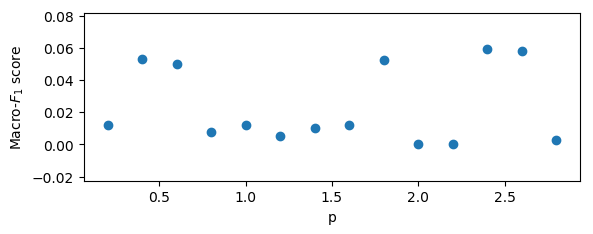

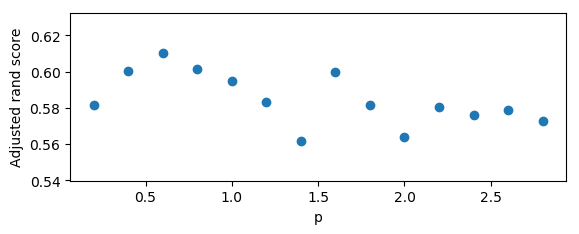

In [51]:
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(p_test['p'], p_test['f1_score'])
plt.xlabel('p')
plt.ylabel('Macro-$F_1$ score')
plt.show()

fig = plt.figure()
fig.add_subplot(212)
plt.scatter(p_test['p'], p_test['adj_score'])
plt.xlabel('p')
plt.ylabel('Adjusted rand score')
plt.show()

In [52]:
# the best scores
print('max f1_score:\n',p_test.loc[p_test['f1_score'].idxmax()], '\n')
print('max adj_score:\n',p_test.loc[p_test['adj_score'].idxmax()])

max f1_score:
 p            2.400000
adj_score    0.576280
f1_score     0.059162
Name: 11, dtype: float64 

max adj_score:
 p            0.600000
adj_score    0.610425
f1_score     0.049673
Name: 2, dtype: float64


__Q paramater's sensitivity check__
* adjusted rand is ok 

In [33]:
Qs = []
adj_scores4 = []
f1_scores4 = []

for i in np.arange(0.2, 3, 0.2): #p
    adj_score4, f1_macro4 = calc_scores(G, departm_dic, clusters_10, 80, 10, 1, i)
    adj_scores4.append(adj_score4)
    f1_scores4.append(f1_macro4)
    Qs.append(i)

q_test = pd.DataFrame(list(zip(Qs, adj_scores4, f1_scores4)), 
               columns =['q','adj_score', 'f1_score']) 

walk_length: 80 , num_walks: 10 , p: 1 , q: 0.2


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:27<00:00,  3.00s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 0.4


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:27<00:00,  3.01s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 0.6000000000000001


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:34<00:00,  4.18s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 0.8


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:27<00:00,  3.00s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1.0


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:28<00:00,  3.04s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1.2


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:29<00:00,  3.07s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1.4000000000000001


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:34<00:00,  3.30s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1.6


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:31<00:00,  3.19s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1.8


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:32<00:00,  3.14s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 2.0


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:32<00:00,  4.06s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 2.2


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:27<00:00,  3.04s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 2.4000000000000004


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:30<00:00,  3.10s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 2.6000000000000005


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:28<00:00,  3.13s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 2.8000000000000003


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [00:27<00:00,  3.01s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


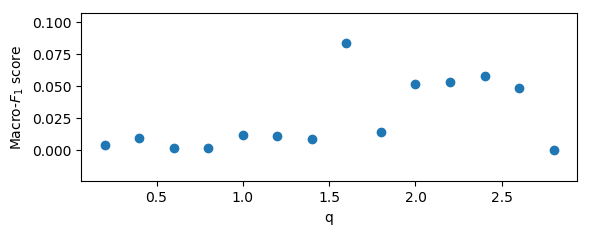

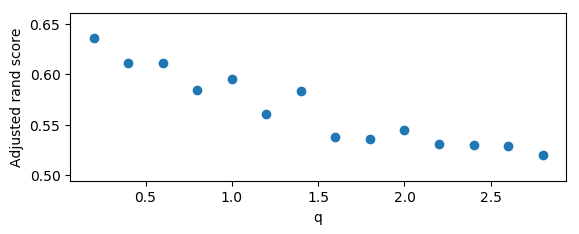

In [53]:
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(q_test['q'], q_test['f1_score'])
plt.xlabel('q')
plt.ylabel('Macro-$F_1$ score')
plt.show()

fig = plt.figure()
fig.add_subplot(212)
plt.scatter(q_test['q'], q_test['adj_score'])
plt.xlabel('q')
plt.ylabel('Adjusted rand score')
plt.show()

In [54]:
# the best scores
print('max f1_score:\n',q_test.loc[q_test['f1_score'].idxmax()], '\n')
print('max adj_score:\n',q_test.loc[q_test['adj_score'].idxmax()])

max f1_score:
 q            1.600000
adj_score    0.537681
f1_score     0.083137
Name: 7, dtype: float64 

max adj_score:
 q            0.200000
adj_score    0.635465
f1_score     0.003738
Name: 0, dtype: float64


## 5. Chosen parametres for Gephi

* Graph = "ten departments only",
* walk_length = 170, 
* num_walks = 39, 
* p = 0.6, 
* q = 0.2,
* num_clusters = 10

In [58]:
#node2vec
walk_length = 170
num_walks = 39
p = 0.6
q = 0.2
num_clusters = 10
lables_dic = departm_dic

node2vec = Node2Vec(G, dimensions=10, walk_length = walk_length, num_walks=num_walks, p=p, q=q)
model = node2vec.fit(window=10, min_count=1)

#clustering
print('clustering started')
X = model[model.wv.vocab]    
kmeans = cluster.KMeans(n_clusters=num_clusters, random_state=25)
kmeans.fit(X)
assigned_clusters = kmeans.labels_

#labels sorting: so assigned_clusters and sorted_lables are in the same order of nodes 
sorted_lables = []
nodes_order = []
nodes = list(model.wv.vocab)
for i, node in enumerate(nodes):
    nodes_order.append(int(node))
    sorted_lables.append(lables_dic[int(node)])

#scores
adj_rand_score = adjusted_rand_score(assigned_clusters, sorted_lables)
#     f1_macro = f1_score(np.unique(sorted_lables), np.unique(assigned_clusters), 
#                         average='macro', labels=np.unique(assigned_clusters))  
f1_macro = f1_score(sorted_lables, assigned_clusters, average='micro') 

TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 39/39 [05:00<00:00,  9.02s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [61]:
print ('adj_rand_score - ', adj_rand_score, '\tf1_macro - ', f1_macro)

adj_rand_score -  0.7457932741520663 	f1_macro -  0.1637323943661972


## 6. Prepare input for Gephi:
We'll output our data into a format recognizable by Gephi.

In [63]:
clusters_df = pd.DataFrame(columns=['node', 'cluster', 'department'])

clusters_df['cluster'] = assigned_clusters
clusters_df['node'] = nodes_order
clusters_df['department'] = sorted_lables

clusters_df.head()

node  cluster  department
0   754        1          14
1   510        1          14
2   504        1          14
3   912        1          14
4   526        5           4

In [83]:
len(clusters_df)

568

In [84]:
len(pd.unique(clusters_df['node']))

568

In [87]:
clusters_df.head()

node  cluster  department
0   754        1          14
1   510        1          14
2   504        1          14
3   912        1          14
4   526        5           4

In [94]:
with open('emails_clusters.gdf', 'w') as f:
    f.write('nodedef>name VARCHAR,cluster_id VARCHAR, Label VARCHAR, dep_name INT\n')
    for index, row in clusters_df.iterrows():
        f.write('{},{},{},{}\n'.format(row['node'], row['cluster'], row['cluster'], row['department']))
    f.write('edgedef>source VARCHAR,target VARCHAR\n')
    for index, row in ten_edges.iterrows(): 
        f.write('{},{}\n'.format(row['from'], row['to']))

## 7. Another calculations

__EMAILS: full data__

In [ ]:
#num walks test
walk_lengths_arr = []
num_walks_arr = []
adj_scores = []
f1_scores = []
clusters_42 = 42

for i in range(80, 90, 10): #walk_length = 80
    for j in range(6, 25, 1): # num_walks = 10
        adj_score, f1_macro = calc_scores(G_full, departm_dic, clusters_42, i, j)
        adj_scores.append(adj_score)
        f1_scores.append(f1_macro)
        walk_lengths_arr.append(i)
        num_walks_arr.append(j)

walks_test = pd.DataFrame(list(zip(walk_lengths_arr, num_walks_arr, adj_scores, f1_scores)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

In [ ]:
fig = plt.figure()
fig.add_subplot(111)
plt.scatter(walks_test['num_walks'], walks_test['f1_score'])
plt.xlabel('Number of walks per node, n')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()


In [ ]:
walk_lengths_arr2 = []
num_walks_arr2 = []
adj_scores2 = []
f1_scores2 = []

for i in range(40, 130, 10): #walk_length = 80
    for j in range(10, 11, 1): # num_walks = 10
        adj_score2, f1_macro2 = calc_scores(G_full, departm_dic, clusters_42, i, j)
        adj_scores2.append(adj_score2)
        f1_scores2.append(f1_macro2)
        walk_lengths_arr2.append(i)
        num_walks_arr2.append(j)

length_test = pd.DataFrame(list(zip(walk_lengths_arr2, num_walks_arr2, adj_scores2, f1_scores2)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

In [ ]:
fig = plt.figure()
fig.add_subplot(111)
plt.scatter(length_test['walk_length'], length_test['f1_score'])
plt.xlabel('Length of walk, l')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

In [ ]:
Ps = []
adj_scores3 = []
f1_scores3 = []

for i in np.arange(0.2, 3, 0.2): #p
    adj_score3, f1_macro3 = calc_scores(G_full, departm_dic, clusters_42, 80, 10, i)
    adj_scores3.append(adj_score3)
    f1_scores3.append(f1_macro3)
    Ps.append(i)

p_test = pd.DataFrame(list(zip(Ps, adj_scores3, f1_scores3)), 
               columns =['p','adj_score', 'f1_score']) 

In [ ]:
log2Ps = []

for p in Ps:
    log2Ps.append(math.log(p, 2.0))

fig = plt.figure()
fig.add_subplot(111)
plt.scatter(log2Ps, p_test['f1_score'])
plt.xlabel('$\log_2 q$')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

In [ ]:
Qs = []
adj_scores4 = []
f1_scores4 = []



for i in np.arange(0.2, 3, 0.2): #p
    adj_score4, f1_macro4 = calc_scores(G_full, departm_dic, clusters_42, 80, 10, 1, i)
    adj_scores4.append(adj_score4)
    f1_scores4.append(f1_macro4)
    Qs.append(i)

q_test = pd.DataFrame(list(zip(Qs, adj_scores4, f1_scores4)), 
               columns =['q','adj_score', 'f1_score']) 

In [ ]:
log2Qs = []

for q in Qs:
    log2Qs.append(math.log(q, 2.0))
    
print(log2Qs)

In [ ]:
fig = plt.figure()
fig.add_subplot(111)
plt.scatter(log2Qs, q_test['f1_score'])
plt.xlabel('$\log_2 q$')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

__Blogs network__

In [ ]:
blog_edges = pd.read_csv('C:/Users/gatauade/Documents/CVUT/bakalarka/BP_2019_utf8/bp/data/BlogCatalog-dataset/data/edges.csv')
blog_edges.columns=['id1', 'id2']
print('blog_edges\n', blog_edges.head())

groups = pd.read_csv('C:/Users/gatauade/Documents/CVUT/bakalarka/BP_2019_utf8/bp/data/BlogCatalog-dataset/data/group-edges.csv', header=None)
groups.columns=['id', 'group']
# groups = groups.sort_indexa()

print('groups\n',groups.head())

In [ ]:
len(pd.unique(pd.concat([blog_edges['id1'], blog_edges['id2']], sort=False)))

In [ ]:
print('unique:' , len(pd.unique(pd.concat([groups['id']], sort=False))), 'vs. all:', len(groups))

In [ ]:
ids = groups["id"]
groups[ids.duplicated(keep=False)]
for i, group in groups.iterrows():
    if group['id'] == 28:
        print(group)

In [ ]:
#some blogers belongs to a few groups simultaneously -> keep the first value only
groups = groups.drop_duplicates(subset='id', keep="first")

In [ ]:
len(groups)

In [ ]:
groups_dic = {}

for x, row in groups.iterrows():
    groups_dic[row[0]] = row[1]
# print(groups_dic)

In [ ]:
G_blog = nx.Graph()
G_blog.add_nodes_from(blog_edges['id1'])
G_blog.add_nodes_from(blog_edges['id2'])

for index, row in blog_edges.iterrows():
    G_blog.add_edge(row["id1"], row["id2"], weight = 1)

In [ ]:
len(G_blog)

In [ ]:
groups_freq = groups['group'].value_counts()
groups_freq = groups_freq.sort_index()
groups_freq.index

In [ ]:
blog_performance = []
blog_objects = groups_freq.index
for i in blog_objects:
    if (i in groups_freq):
        blog_performance.append(groups_freq[i])
y_pos = np.arange(len(blog_objects))

plt.bar(y_pos, blog_performance, align='center', alpha=0.5)
plt.xticks(y_pos, blog_objects)
plt.ylabel('Number of users')
plt.xlabel('Groups')
plt.title('Number of members in groups')

plt.show()

In [ ]:
lengths = []
num_ws = []
adj_scs = []
f1_scs = []
clusters_39 = 39

for i in range(80, 90, 10): #walk_length = 80
    for j in range(6, 20, 1): # num_walks = 10
        adj_sc, f1_m = calc_scores(G_blog, groups_dic, clusters_39, i, j)
        adj_scs.append(adj_sc)
        f1_scs.append(f1_m)
        lengths.append(i)
        num_ws.append(j)

blog_walks_test = pd.DataFrame(list(zip(lengths, num_ws, adj_scs, f1_scs)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

In [ ]:
fig = plt.figure()
fig.add_subplot(111)
plt.scatter(blog_walks_test['num_walks'], blog_walks_test['f1_score'])
plt.xlabel('Number of walks per node, n')
plt.ylabel('Macro-$F_1$ score')
plt.show()

In [ ]:
walk_lengths_arr2 = []
num_walks_arr2 = []
adj_scores2 = []
f1_scores2 = []

for i in range(50, 100, 10): #walk_length = 80
    for j in range(10, 11, 1): # num_walks = 10
        adj_score2, f1_macro2 = calc_scores(G_blog, groups_dic, clusters_39, i, j)
        adj_scores2.append(adj_score2)
        f1_scores2.append(f1_macro2)
        walk_lengths_arr2.append(i)
        num_walks_arr2.append(j)

blog_length_test = pd.DataFrame(list(zip(walk_lengths_arr2, num_walks_arr2, adj_scores2, f1_scores2)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

In [ ]:
Ps = []
adj_scores3 = []
f1_scores3 = []

for i in np.arange(0.4, 2, 0.2): #p
    adj_score3, f1_macro3 = calc_scores(G_blog, groups_dic, clusters_39, 80, 10, i)
    adj_scores3.append(adj_score3)
    f1_scores3.append(f1_macro3)
    Ps.append(i)

blog_p_test = pd.DataFrame(list(zip(Ps, adj_scores3, f1_scores3)), 
               columns =['p','adj_score', 'f1_score']) 

In [ ]:
Qs = []
adj_scores4 = []
f1_scores4 = []

for i in np.arange(0.4, 2, 0.2): #p
    adj_score4, f1_macro4 = calc_scores(G_blog, groups_dic, clusters_39, 80, 10, 1, i)
    adj_scores4.append(adj_score4)
    f1_scores4.append(f1_macro4)
    Qs.append(i)

blog_q_test = pd.DataFrame(list(zip(Qs, adj_scores4, f1_scores4)), 
               columns =['q','adj_score', 'f1_score']) 

In [ ]:
fig = plt.figure()
fig.add_subplot(111)
plt.scatter(blog_length_test['walk_length'], length_test['f1_score'])
plt.xlabel('Length of walk, l')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

In [ ]:
log2Ps = []

for p in Ps:
    log2Ps.append(math.log(p, 2.0))

fig = plt.figure()
fig.add_subplot(111)
plt.scatter(log2Ps, blog_p_test['f1_score'])
plt.xlabel('$\log_2 q$')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

In [ ]:
log2Qs = []

for q in Qs:
    log2Qs.append(math.log(q, 2.0))
    
fig = plt.figure()
fig.add_subplot(111)
plt.scatter(log2Qs, blog_q_test['f1_score'])
plt.xlabel('$\log_2 q$')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

__scores test__

In [ ]:
#scores test 
from sklearn.metrics import f1_score
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 3, 0, 2, 3]
print(
    'f1_scores: macro - ', f1_score(np.unique(y_true), np.unique(y_pred), average='macro',labels=np.unique(y_pred)),  
    '\nmicro - ', f1_score(y_true, y_pred, average='micro'), 
    '\nweighted - ',f1_score(y_true, y_pred, average='weighted'),  
    '\nnone - ',f1_score(y_true, y_pred, average=None),
      '\nadjusted_rand - ', adjusted_rand_score(y_true, y_pred))